In [1]:
include("../../src/CoherentStructures.jl") #this is terrible but neccessary during development (?)

Main.CoherentStructures

In [2]:
normalizeUL2(u,M) = u.*sign.(sum(u))./ sqrt(u'*M*u);

In [3]:
using StreamMacros, Main.CoherentStructures
using Tensors, Arpack, JLD2, OrdinaryDiffEq
using Plots

In [4]:
JLD2.@load("Ocean_geostrophic_velocity.jld2");
UV = interpolateVF(Lon, Lat, Time, UT, VT);

In [5]:
function add_wind(p)
    lattitude_range = range(minimum(Lat),maximum(Lat),length=size(UT)[2]) # should be equal to Lat, but just to be safe
    wind_u = repeat(collect(wind_scale.*(lattitude_range.-wind_center))',size(UT)[1],1,size(UT)[3])
    wind_v = zero(VT); #no northward component of wind
    UT_wind = UT + p*wind_u
    VT_wind = VT + p*wind_v
    return interpolateVF(Lon, Lat, Time, UT_wind, VT_wind)
end

add_wind (generic function with 1 method)

In [6]:
# Parameters
grid_resolution        = 200
quadrature_order       = 5
ϵ                      = 5                # perturbation
nev                    = 10
t_initial              = minimum(Time)
t_end                  = t_initial+70     # parameter value corresponding to ϵ=0
wind_scale             = 1e-5
wind_center            = 30
solver_tolerance       = 1e-9
solver                 = OrdinaryDiffEq.BS5();

In [7]:
lattitude_range = range(minimum(Lat),maximum(Lat),length=size(UT)[2]) # should be equal to Lat, but just to be safe
wind_u = repeat(collect(wind_scale.*(lattitude_range.-wind_center))',size(UT)[1],1,size(UT)[3])
wind_v = zero(VT); #no northward component of wind
wind = interpolateVF(Lon, Lat, Time, wind_u, wind_v);

In [8]:
# it would be much easier to write this with interp_rhs and p=UV .+ param.*wind, but that has the wrong type
interp_rhs_scaled = OrdinaryDiffEq.ODEFunction{false}((u,p,t) -> p[1](u[1],u[2],t) .+ p[3].*p[2](u[1],u[2],t))
function T(x,param)
    flow(interp_rhs_scaled, x, [t_initial, t_end]; 
        p=(UV, wind, param), tolerance=solver_tolerance, solver=solver)[end]
end

T (generic function with 1 method)

In [9]:
LL, UR = (-4.0, -34.0), (6.0, -28.0)
lon_resolution = grid_resolution
lat_resolution = Integer(floor((UR[2] - LL[2])/(UR[1] - LL[1])*grid_resolution))
ctx, _ = regularTriangularGrid((lon_resolution, lat_resolution), 
        LL, UR, quadrature_order = quadrature_order);
bdata = getHomDBCS(ctx, "all");

In [10]:
M = assembleMassMatrix(ctx, bdata=bdata);

In [11]:
# assemble K
DT₀(x) = linearized_flow_autodiff(y -> T(y,0) , x)
A₀(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DT₀(x))))
@time K = assembleStiffnessMatrix(ctx, A₀, bdata=bdata);

 89.601917 seconds (95.48 M allocations: 5.416 GiB, 1.55% gc time)


In [12]:
DTϵ(x) = linearized_flow_autodiff(y -> T(y,ϵ) , x)
Aϵ(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DTϵ(x))))
Kϵ = assembleStiffnessMatrix(ctx, Aϵ, bdata=bdata);

In [13]:
# assemble the linear response matrix L
Adot = x -> linear_response_tensor(T, x, 0)
@time L = assembleStiffnessMatrix(ctx, Adot, bdata=bdata);

LoadError: [91msyntax: extra token "the" after end of expression[39m

In [55]:
# solve the linear system
@time λ₀, u₀ = eigs(K, M, which=:SM, nev=nev)
@assert all(imag.(u₀) .== 0)
@assert all(imag.(λ₀) .== 0)
u₀ = real.(u₀)
λ₀ = real.(λ₀)
for i in 1:size(u₀)[2]
    u₀[:,i] = normalizeUL2(u₀[:,i],M)
end

  0.444427 seconds (306.51 k allocations: 97.158 MiB, 4.15% gc time)


In [15]:
# calculate the exact uϵ
λϵ, uϵ = eigs(Kϵ, M, which=:SM, nev=nev)
@assert all(imag.(uϵ) .== 0)
@assert all(imag.(λϵ) .== 0)
uϵ = real.(uϵ)
λϵ = real.(λϵ)
for i in 1:size(uϵ)[2]
    uϵ[:,i] = normalizeUL2(uϵ[:,i],M)
end

In [16]:
 solve the system for the derivative u_dot
u_dot = zero(u₀)
λ_dot = zero(λ₀)
for i in 1:size(u₀)[2] 
    @time u_dot[:,i], λ_dot[i] = getLinearResponse(u₀[:,i],λ₀[i],M,K,L)
end

LoadError: [91msyntax: extra token "the" after end of expression[39m

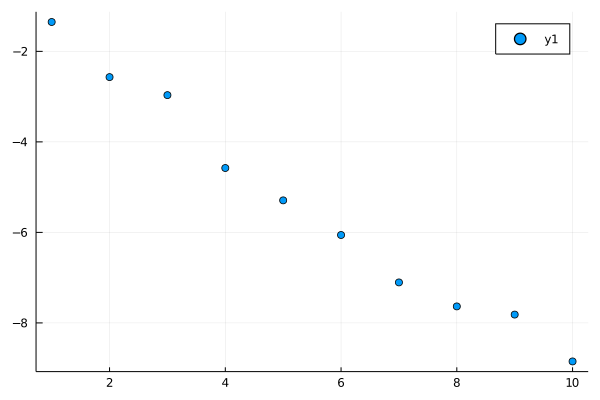

In [17]:
#select number of evs
Plots.scatter(1:nev,λ₀)

In [56]:
nev = 4
u₀ = u₀[:,1:nev]
λ₀ = λ₀[1:nev]
uϵ = uϵ[:,1:nev]
λϵ = λϵ[1:nev]
#u_dot = u_dot[:,1:nev]
#λ_dot = λ_dot[1:nev];

BoundsError: [91mBoundsError: attempt to access 23364×3 Array{Float64,2} at index [Base.Slice(Base.OneTo(23364)), 1:4][39m

In [19]:
for i in 1:nev
    print("exact ev"*string(i)*": "*string(λϵ[i])*
        "\t predicted ev"*string(i)*": "*string(λ₀[i] + ϵ*λ_dot[i])*
        "\t relative error: "*string(abs(λ₀[i] + ϵ*λ_dot[i] - λϵ[i])/abs(λϵ[i]))*"\n")
end

UndefVarError: [91mUndefVarError: λ_dot not defined[39m

In [20]:
color =    :balance
xticks =   -4:2:6
yticks =   -34:2:-28
colorbar = :left
cmins =     [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
cmaxs =     -cmins
cmins_lr =  [-10, -10, -10, -10, -10, -10, -10, -10,-10, -10, -10, -10]
cmaxs_lr =  -cmins_lr;

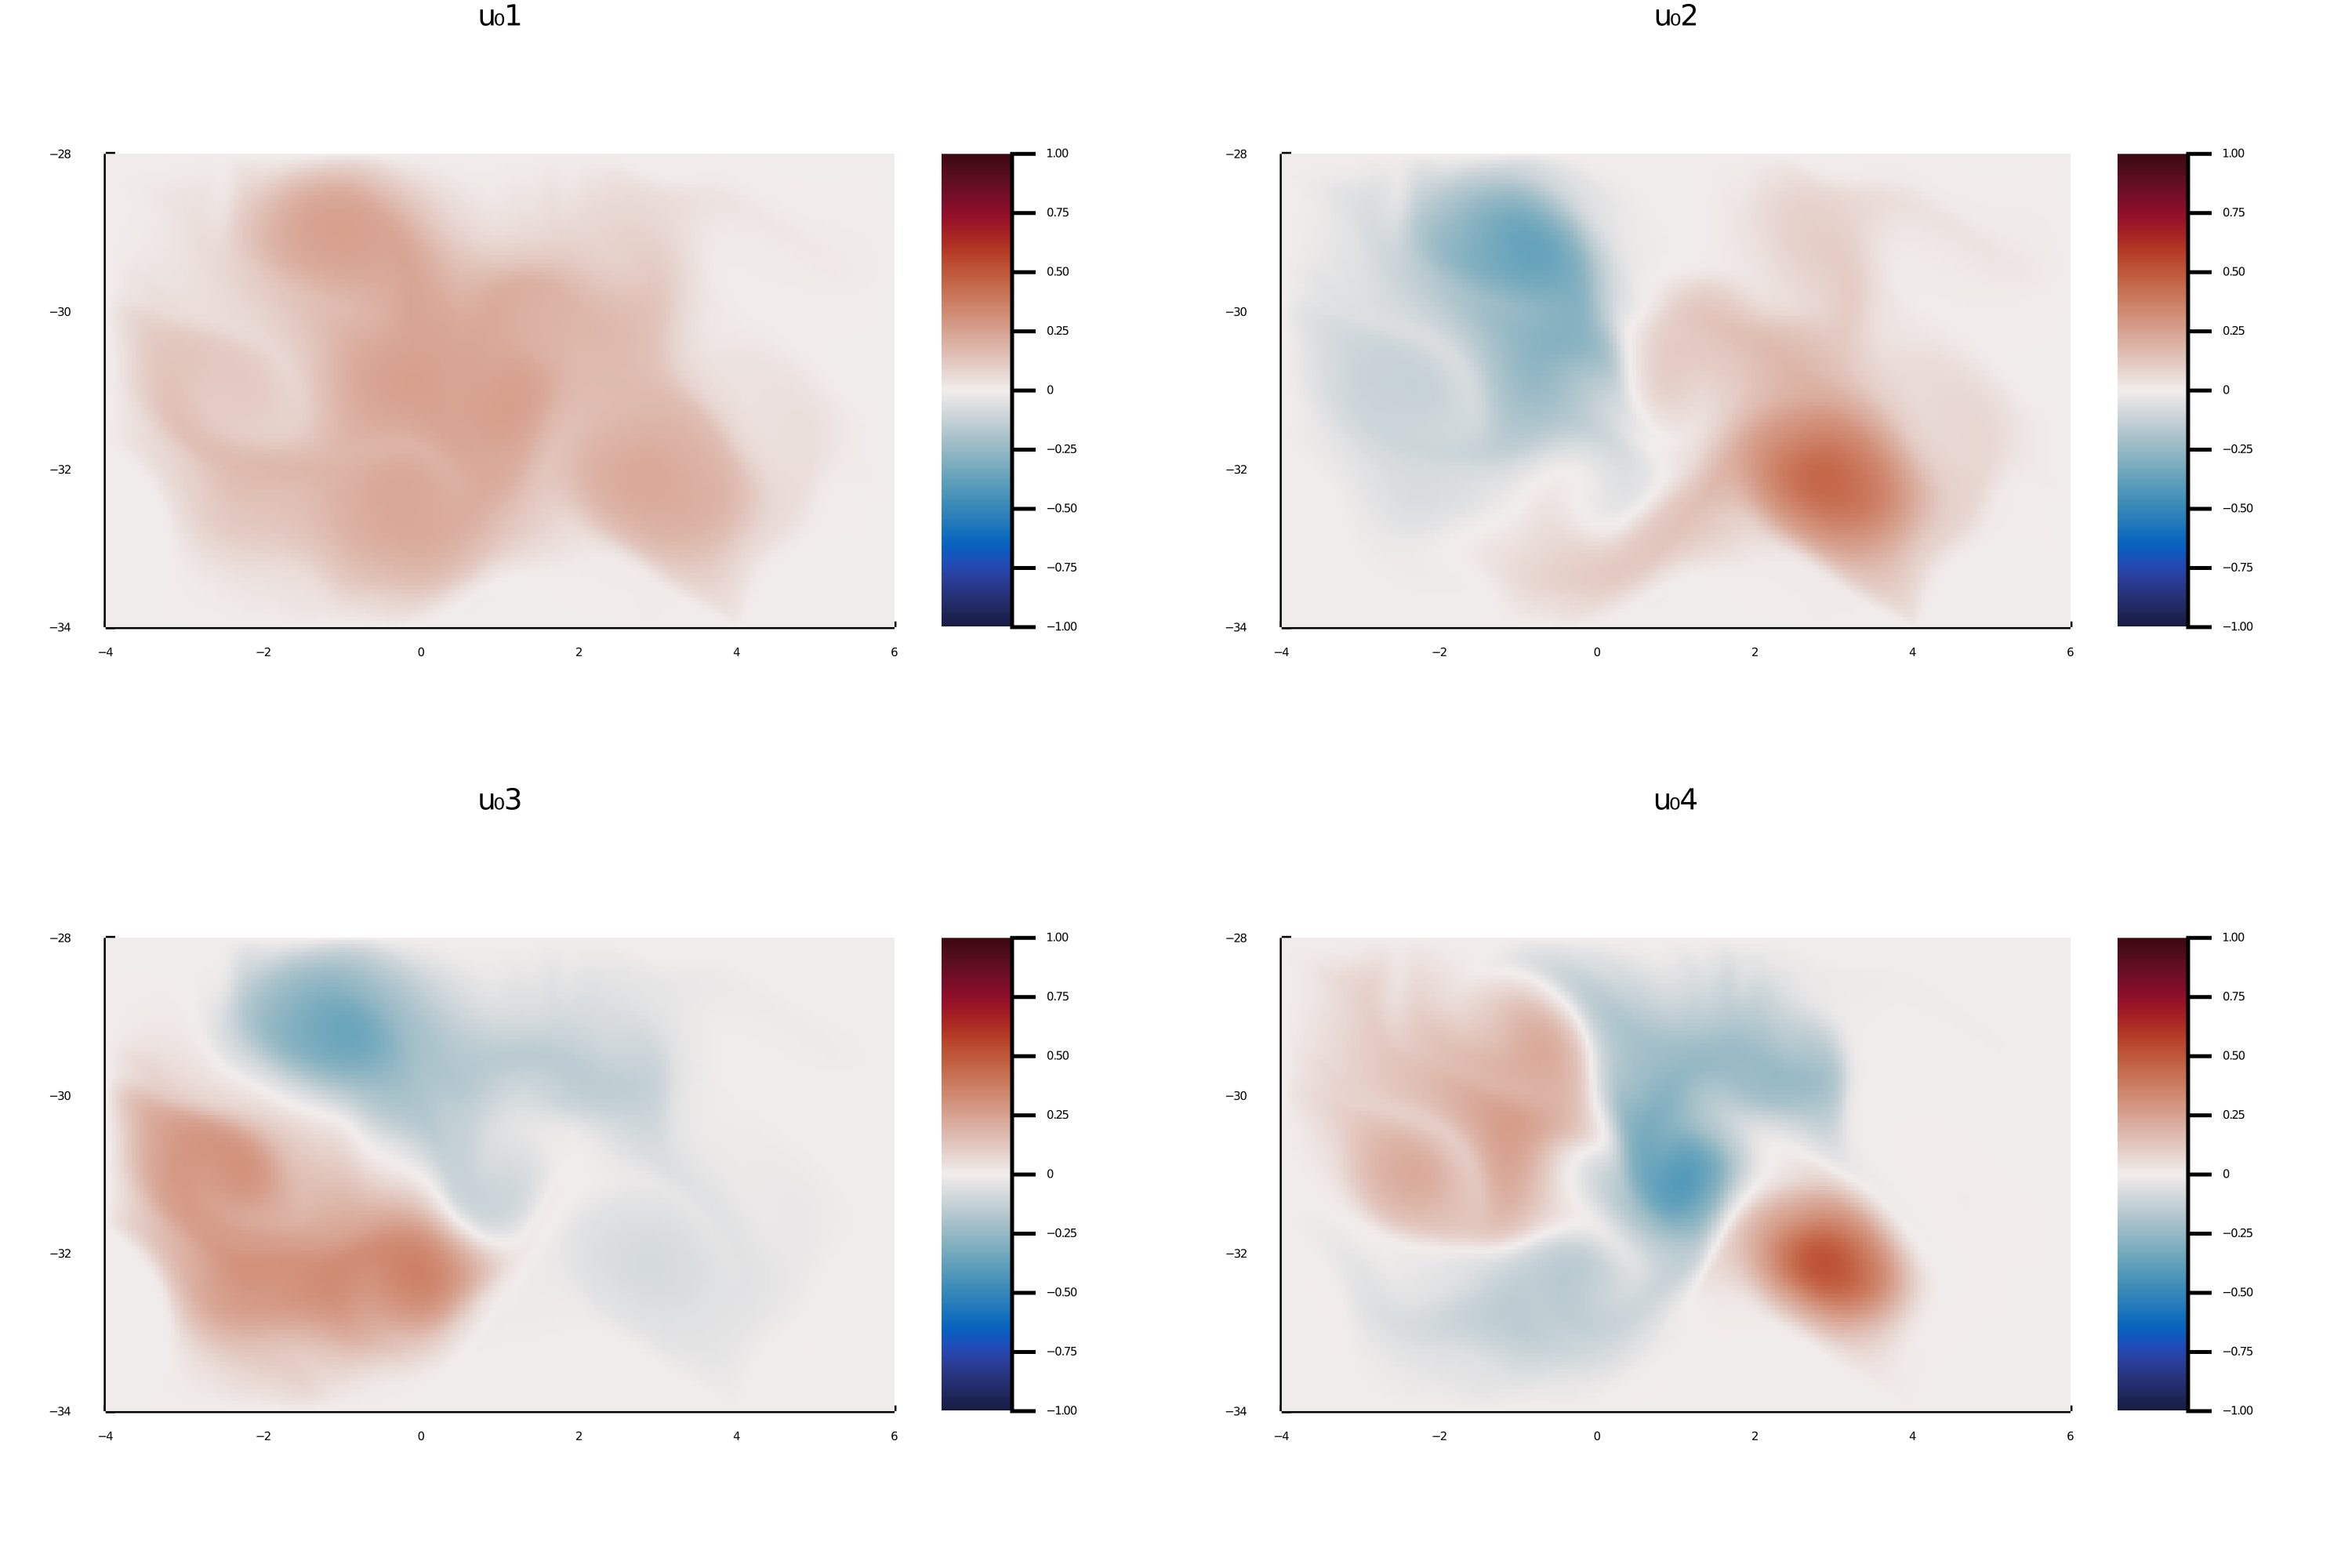

In [57]:
plots = []
for i in 1:nev
    push!(plots,plot_u(ctx, u₀[:,i],  lon_resolution, lat_resolution, bdata=bdata,
            title="u₀"*string(i), 
                colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
#    push!(plots,plot_u(ctx, u_dot[:,i],  lon_resolution, lat_resolution, bdata=bdata,
#            title="̇u₀"*string(i), 
#        colorbar=colorbar, color=color, clims=(cmins_lr[i],cmaxs_lr[i]), xticks=xticks, yticks=yticks))
#    push!(plots,plot_u(ctx, u₀[:,i] + ϵ*u_dot[:,i],  lat_resolution, grid_resolution, bdata=bdata,
#            title="u₀"*string(i)*" + $(ϵ)u̇ ₀"*string(i), 
#    colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
#    push!(plots,plot_u(ctx, uϵ[:,i],  lon_resolution, lat_resolution, bdata=bdata,
#              title="uϵ"*string(i), 
#            colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
end
Plots.plot(plots..., fmt=:png, dpi=500,#layout=grid(nev,2),
            xtickfontsize=2,ytickfontsize=2,xguidefontsize=2,yguidefontsize=2,legendfontsize=5,titlefontsize=5)

In [22]:
#limit ourse'lves to one ev for plotting etc.
ev = 1

1

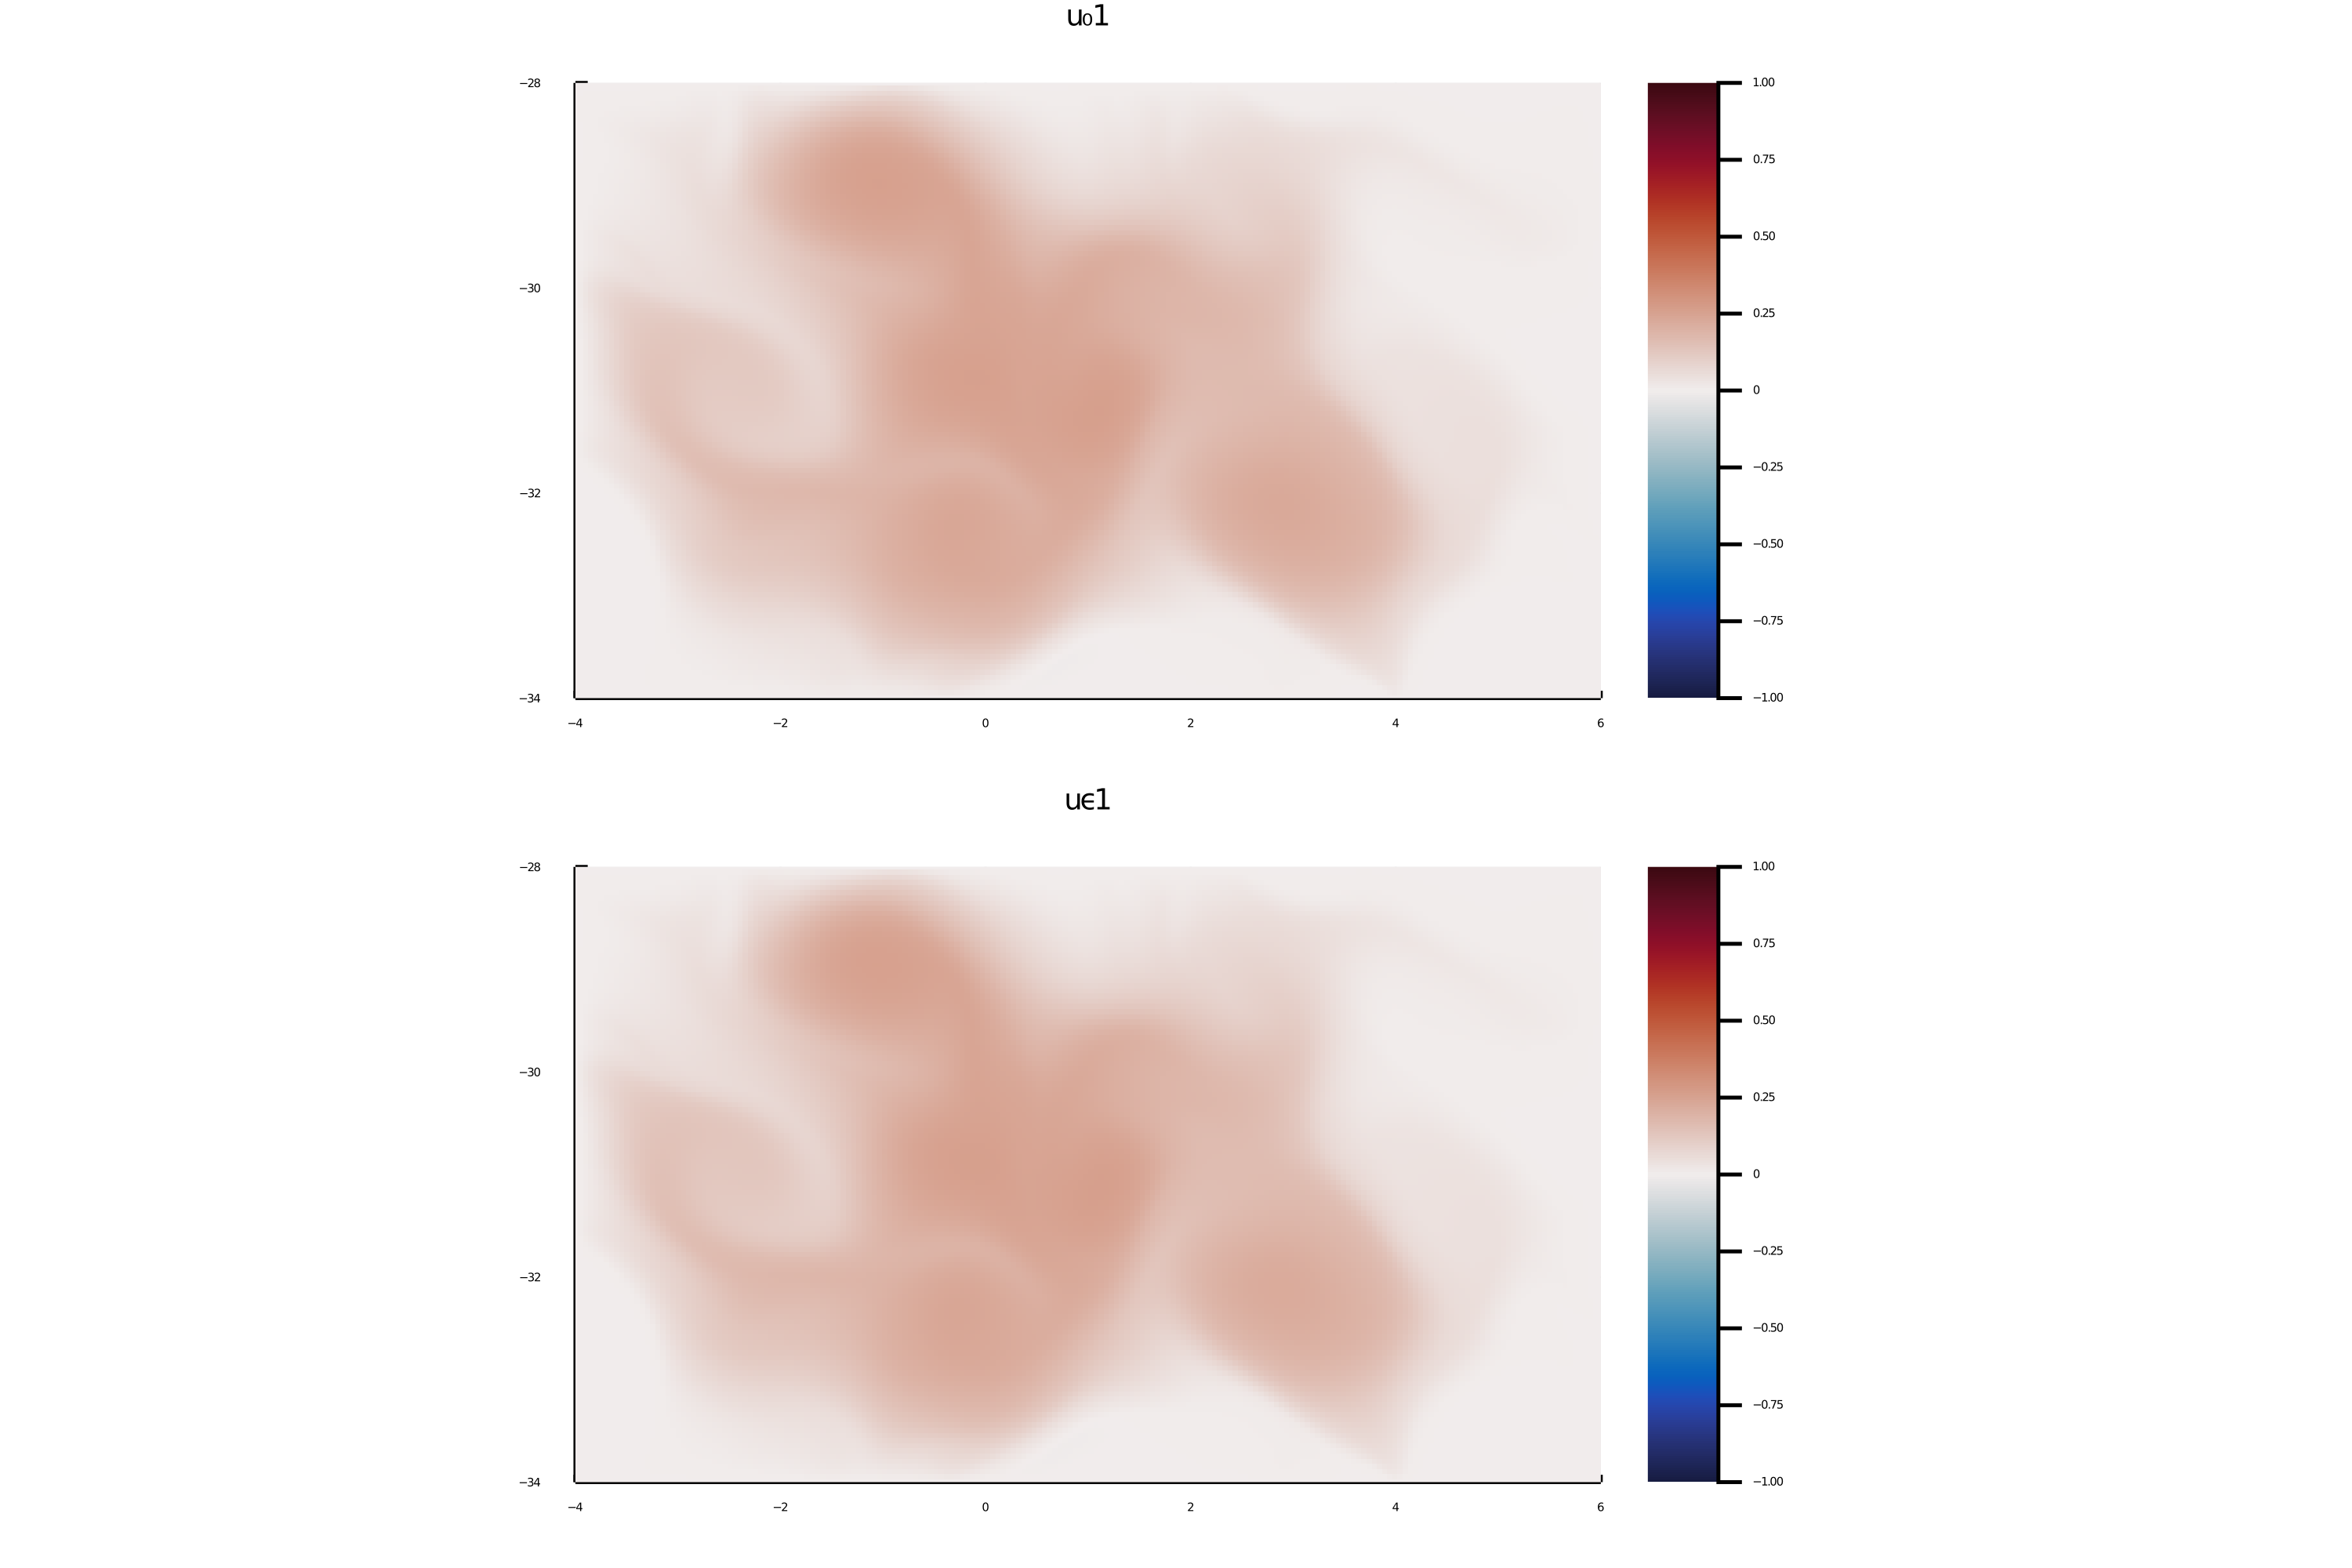

In [23]:
plots = []
push!(plots,plot_u(ctx, u₀[:,ev],  lon_resolution, lat_resolution, bdata=bdata,
        title="u₀"*string(ev), 
            colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks))
#push!(plots,plot_u(ctx, u_dot[:,ev],  lon_resolution, lat_resolution, bdata=bdata,
#        title="̇u₀"*string(ev), 
#    colorbar=colorbar, color=color, clims=(cmins_lr[ev],cmaxs_lr[ev]), xticks=xticks, yticks=yticks))
#push!(plots,plot_u(ctx, u₀[:,ev] + ϵ*u_dot[:,ev],  lon_resolution, lat_resolution, bdata=bdata,
#        title="u₀"*string(ev)*" + $(ϵ)u̇ ₀"*string(ev), 
#colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks))
push!(plots,plot_u(ctx, uϵ[:,ev],  lon_resolution, lat_resolution, bdata=bdata,
        title="uϵ"*string(ev), 
        colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks))
Plots.plot(plots..., fmt=:png, dpi=500,layout=grid(2,1),
            xtickfontsize=2,ytickfontsize=2,xguidefontsize=2,yguidefontsize=2,legendfontsize=5,titlefontsize=5)

## Contour Plots

In [24]:
using Contour

In [25]:
import Main.CoherentStructures:dynamic_cheeger_value
dynamic_cheeger_value(c) = dynamic_cheeger_value(ctx,c,x->T(x,0);tolerance=1e-10)

dynamic_cheeger_value (generic function with 2 methods)

In [26]:
# Just here to compare with the matlab function

function isClosed(curve)
   return Main.CoherentStructures.closeCurve(ctx,curve,tolerance=1e-10) == curve
end

function dynamic_cheeger_value_matlab(curve)
    image_curve   = Main.CoherentStructures.apply2curve(x->T(x,ϵ),curve)
    
    if !isClosed(curve) || !isClosed(image_curve)
        return Inf
    end
    
    return 0.5(Main.CoherentStructures.getLength(curve)/Main.CoherentStructures.getEuclideanArea(ctx,curve,tolerance=1e-10) +
        Main.CoherentStructures.getLength(image_curve)/Main.CoherentStructures.getEuclideanArea(ctx,image_curve,tolerance=1e-10))
end

dynamic_cheeger_value_matlab (generic function with 1 method)

In [27]:
# resoultion for the levelset methods (default should be 'nothing', that way the grid resolution is used)
x_resolution = 500
y_resolution = Integer(floor((UR[2] - LL[2])/(UR[1] - LL[1])*x_resolution));

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.007877867998733273)
└ @ Main In[28]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.00325588626787719)
└ @ Main In[28]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.002984004989591538)
└ @ Main In[28]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.002712123711305886)
└ @ Main In[28]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.002440242433020234)
└ @ Main In[28]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.002168361154734582)
└ @ Main In[28]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.0018964798764489299)
└ @ Main In[28]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.001624598598163278)
└ @ Main In[28]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: "

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.1854297208623653)
└ @ Main In[28]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.18570160214065096)
└ @ Main In[28]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.1859734834189366)
└ @ Main In[28]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.18624536469722225)
└ @ Main In[28]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.18651724597550792)
└ @ Main In[28]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.18678912725379357)
└ @ Main In[28]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.18706100853207921)
└ @ Main In[28]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.18733288981036486)
└ @ Main In[28]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.18760477108865

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.2052770541772179)
└ @ Main In[28]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.20554893545550354)
└ @ Main In[28]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.2058208167337892)
└ @ Main In[28]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.20609269801207486)
└ @ Main In[28]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.2063645792903605)
└ @ Main In[28]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.20663646056864615)
└ @ Main In[28]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.20690834184693183)
└ @ Main In[28]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.20718022312521747)
└ @ Main In[28]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.207452104403503

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.2251243874920705)
└ @ Main In[28]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.22539626877035615)
└ @ Main In[28]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.2256681500486418)
└ @ Main In[28]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.22594003132692744)
└ @ Main In[28]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.22621191260521312)
└ @ Main In[28]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.22648379388349876)
└ @ Main In[28]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.2267556751617844)
└ @ Main In[28]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.22702755644007006)
└ @ Main In[28]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.227299437718355

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.24986558381606483)
└ @ Main In[28]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.2501374650943505)
└ @ Main In[28]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.2504093463726361)
└ @ Main In[28]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.25068122765092177)
└ @ Main In[28]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.2509531089292074)
└ @ Main In[28]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.2512249902074931)
└ @ Main In[28]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.25149687148577876)
└ @ Main In[28]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.2517687527640644)
└ @ Main In[28]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.25204063404235005

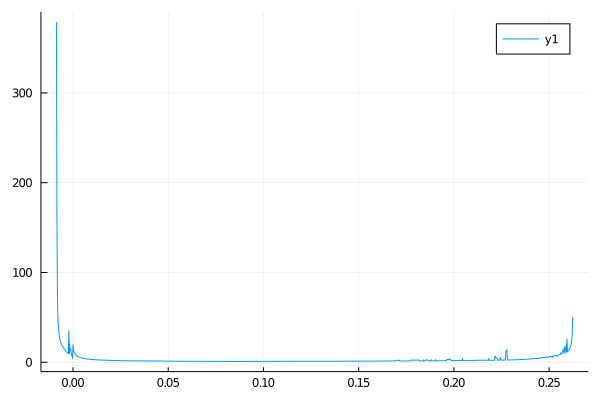

In [28]:
minU = minimum(u₀[:,ev])
maxU = maximum(u₀[:,ev])
values = []
for c in range(minU,stop=maxU,length=1000)
    levelset = Main.CoherentStructures.get_levelset(ctx,u₀[:,ev],c,
        x_resolution=x_resolution,y_resolution=y_resolution,bdata=bdata)
    curves = lines(levelset)
    if (length(curves)>0)
        if length(curves) != 1
            @warn "Currently only connected levelsets are allowed! Levelset: ", level(levelset)
        end
        push!(values,dynamic_cheeger_value(curves[1]))
    else 
        push!(values,0)
    end
end
Plots.plot(range(minU,stop=maxU,length=1000)[2:end-1],values[2:end-1])
Plots.plot!(fmt=:png,dpi=100)

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.025225225225225224)
└ @ Main In[29]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.16966966966966968)
└ @ Main In[29]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.16996996996996996)
└ @ Main In[29]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.17027027027027028)
└ @ Main In[29]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.17057057057057057)
└ @ Main In[29]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.17087087087087088)
└ @ Main In[29]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.17117117117117117)
└ @ Main In[29]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.17147147147147146)
└ @ Main In[29]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.17177177177

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.1912912912912913)
└ @ Main In[29]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.1915915915915916)
└ @ Main In[29]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.1918918918918919)
└ @ Main In[29]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.1921921921921922)
└ @ Main In[29]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.1924924924924925)
└ @ Main In[29]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.1927927927927928)
└ @ Main In[29]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.19309309309309308)
└ @ Main In[29]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.1933933933933934)
└ @ Main In[29]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.19369369369369369)


┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.2132132132132132)
└ @ Main In[29]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.21351351351351353)
└ @ Main In[29]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.2138138138138138)
└ @ Main In[29]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.2141141141141141)
└ @ Main In[29]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.21441441441441442)
└ @ Main In[29]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.2147147147147147)
└ @ Main In[29]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.21501501501501502)
└ @ Main In[29]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.2153153153153153)
└ @ Main In[29]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.21561561561561562

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.23483483483483483)
└ @ Main In[29]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.23513513513513515)
└ @ Main In[29]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.23543543543543544)
└ @ Main In[29]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.23573573573573572)
└ @ Main In[29]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.23603603603603604)
└ @ Main In[29]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.23633633633633633)
└ @ Main In[29]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.23663663663663664)
└ @ Main In[29]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.23693693693693693)
└ @ Main In[29]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.237237237237

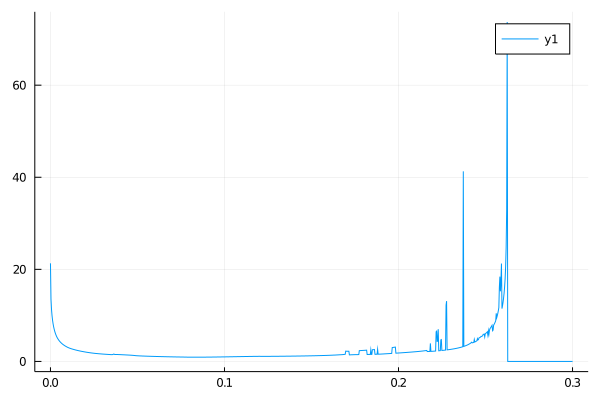

In [29]:
minU = 0
maxU = 0.3
values = []
for c in range(minU,stop=maxU,length=1000)
    levelset = Main.CoherentStructures.get_levelset(ctx,u₀[:,ev],c,
        x_resolution=x_resolution,y_resolution=y_resolution,bdata=bdata)
    curves = lines(levelset)
    if (length(curves)>0)
        if length(curves) != 1
            @warn "Currently only connected levelsets are allowed! Levelset: ", level(levelset)
        end
        push!(values,dynamic_cheeger_value(curves[1]))
    else 
        push!(values,0)
    end
end
Plots.plot(range(minU,stop=maxU,length=1000)[1:end],values[1:end])
Plots.plot!(fmt=:png,dpi=100)

In [30]:
best_levelset, best_value = get_minimal_levelset(
    ctx,u₀[:,ev],dynamic_cheeger_value,
    x_resolution=x_resolution,y_resolution=y_resolution,bdata=bdata,
    n_candidates=1000,min=0)
print("Dynamic Cheeger value:\t",best_value,"\n")
print("Levelset:\t\t",level(best_levelset),"\n")

Dynamic Cheeger value:	0.921089379835365
Levelset:		0.08044951470672682


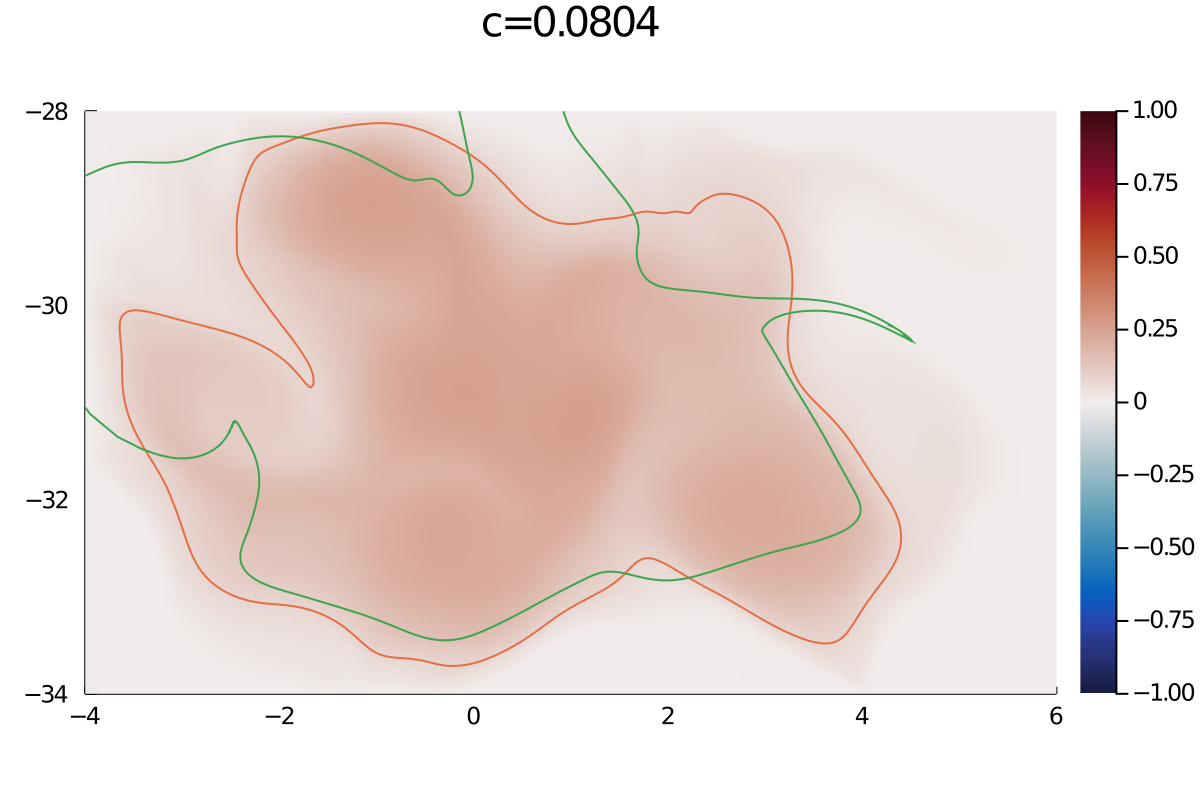

In [31]:
c_best = level(best_levelset)
plot_u(ctx, u₀[:,ev],  lon_resolution, lat_resolution, title="c=$(round(c_best,digits=4))", bdata=bdata,
        colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks,legend=false)

curves = lines(best_levelset)
curves = [Main.CoherentStructures.closeCurve(ctx,c) for c in curves]
curves_moved = [Main.CoherentStructures.apply2curve(x->T(x,0),c) for c in curves]

for c in curves
    Plots.plot!(coordinates(c))
end
for c in curves_moved
    Plots.plot!(coordinates(c))
end
Plots.plot!(fmt=:png,dpi=200,legend=false)

In [32]:
using PyCall
using PyPlot

In [33]:
function plot_vectorfield(xs,ys,dx,dy,ax;scale=1,step=1)
    xs, ys = xs[1:step:end], ys[1:step:end]
    dx, dy = dx[1:step:end,1:step:end], dy[1:step:end,1:step:end]
    ax.quiver(xs,ys,dx',dy',scale=scale,color="blue")
end

plot_vectorfield (generic function with 1 method)

In [34]:
plt.figure(figsize=(10,6), dpi=100)
ax = plt.axes()
ax.set(xlim=(-4,6), ylim=(-34,-28))
plot_vectorfield(get_levelset_evolution(ctx,u₀[:,ev],u_dot[:,ev],bdata=bdata)...,ax,scale=1,step=5)
curves           = lines(get_levelset(ctx, u₀[:,ev],c_best,
        x_resolution=x_resolution,y_resolution=y_resolution,bdata=bdata))
curves_epsilon   = lines(get_levelset(ctx, uϵ[:,ev],c_best,
        x_resolution=x_resolution,y_resolution=y_resolution,bdata=bdata))
curves_predicted = lines(get_levelset(ctx, u₀[:,ev] + ϵ*u_dot[:,ev],c_best,
        x_resolution=x_resolution,y_resolution=y_resolution,bdata=bdata))

for c in curves
    ax.plot(coordinates(c)...,color=:black,linewidth=2)
end
for c in curves_epsilon
    ax.plot(coordinates(c)...,color=:red,linestyle="--",linewidth=2)
end
for c in curves_predicted
    ax.plot(coordinates(c)...,color=:lightgreen,linewidth=2)
end
ax.set_title("c=$(round(c_best,digits=4))");

UndefVarError: [91mUndefVarError: u_dot not defined[39m

## SEBA

In [35]:
using LinearAlgebra

In [36]:
softThreshold(u,μ) = sign.(u) .* max.(abs.(u) .- μ, 0)
normalizeU(u) = u.*sign.(sum(u))/maximum(u*sign.(sum(u)))
normalizeU(u,v) = u.*sign.(sum(v))/maximum(v*sign.(sum(v)));

In [37]:
μ = 0.99/grid_resolution;

In [38]:
@time S, R = SEBA(u₀,μ=μ,returnR=true,sort=false);

  1.565797 seconds (6.54 M allocations: 400.752 MiB, 6.50% gc time)


In [39]:
order = sortperm([-minimum(S[:,i]) for i in 1:nev]);

In [40]:
# This is the matrix we effectively multiply u₀ with
Rot = inv(qr(u₀).R)*R'

3×3 Array{Float64,2}:
 -0.0291389   0.0311584   -0.0266967
  0.0305717   0.0383158    0.0113528
  0.0273518  -0.00964442  -0.0411152

In [41]:
S_dot = u_dot*Rot;

UndefVarError: [91mUndefVarError: u_dot not defined[39m

In [42]:
Sϵ, Rϵ = SEBA(uϵ,μ=μ,returnR=true,sort=false);

In [43]:
S′ = Matrix(qr(u₀).Q)*R';

In [44]:
Sϵ′ = Matrix(qr(uϵ).Q)*Rϵ';

In [45]:
plots = []
for i in 1:nev
    push!(plots,plot_u(ctx, normalizeU(S′[:,i]),  
            lon_resolution, lat_resolution, bdata=bdata,
            title="S"*string(i), 
            colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, normalizeU(S_dot[:,i],S′[:,i]),  
            lon_resolution, lat_resolution, bdata=bdata,
            title="̇S"*string(i), 
            colorbar=colorbar, color=color, clims=(cmins_lr[i],cmaxs_lr[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, normalizeU(S′[:,i] + ϵ*S_dot[:,i]),  
            lon_resolution, lat_resolution, bdata=bdata,
            title="S"*string(i)*" + $(ϵ)̇S"*string(i), 
            colorbar=colorbar, color=color, clims=(cmins_lr[i],cmaxs_lr[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, normalizeU(Sϵ′[:,i]),  
            lon_resolution, lat_resolution, bdata=bdata,
            title="Sϵ"*string(i), 
            colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
end
Plots.plot(plots..., fmt=:png, dpi=500,layout=(nev,4),
            xtickfontsize=2,ytickfontsize=2,xguidefontsize=2,yguidefontsize=2,legendfontsize=5,titlefontsize=5)

UndefVarError: [91mUndefVarError: S_dot not defined[39m

In [46]:
plots = []
for i in 1:nev
    push!(plots,plot_u(ctx, S[:,i],  
            lon_resolution, lat_resolution, bdata=bdata,
            title="S"*string(i), 
            colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, normalizeU(S_dot[:,i],S′[:,i]),  
            lon_resolution, lat_resolution, bdata=bdata,
            title="̇S"*string(i), 
            colorbar=colorbar, color=color, clims=(cmins_lr[i],cmaxs_lr[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, normalizeU(softThreshold(S′[:,i] + ϵ*S_dot[:,i],μ)),  
            lon_resolution, lat_resolution, bdata=bdata,
            title="S"*string(i)*" + $(ϵ)̇S"*string(i), 
            colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, Sϵ[:,i],  
            lon_resolution, lat_resolution, bdata=bdata,
            title="Sϵ"*string(i), 
            colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
end
Plots.plot(plots..., fmt=:png, dpi=500,layout=(nev,4),
            xtickfontsize=2,ytickfontsize=2,xguidefontsize=2,yguidefontsize=2,legendfontsize=5,titlefontsize=5)

UndefVarError: [91mUndefVarError: S_dot not defined[39m

In [47]:
plots = []
push!(plots,plot_u(ctx, normalizeU(S′[:,ev]),  
        grid_resolution, grid_resolution, 
        title="S"*string(ev), 
        colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks))
push!(plots,plot_u(ctx, normalizeU(S_dot[:,ev],S′[:,ev]),  
        grid_resolution, grid_resolution, 
        title="̇S"*string(ev), 
        colorbar=colorbar, color=color, clims=(cmins_lr[ev],cmaxs_lr[ev]), xticks=xticks, yticks=yticks))
push!(plots,plot_u(ctx, normalizeU(S′[:,ev] + ϵ*S_dot[:,ev]),  
        grid_resolution, grid_resolution, 
        title="S"*string(ev)*" + $(ϵ)̇S"*string(ev), 
        colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks))
push!(plots,plot_u(ctx, normalizeU(Sϵ′[:,ev]),  
        grid_resolution, grid_resolution, 
        title="Sϵ"*string(ev), 
        colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks))
Plots.plot(plots..., fmt=:png, dpi=500,layout=(2,2),
            xtickfontsize=2,ytickfontsize=2,xguidefontsize=2,yguidefontsize=2,legendfontsize=5,titlefontsize=5)

UndefVarError: [91mUndefVarError: S_dot not defined[39m

In [48]:
plots = []
push!(plots,plot_u(ctx, S[:,ev],  
        grid_resolution, grid_resolution, 
        title="S"*string(ev), 
        colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks))
push!(plots,plot_u(ctx, normalizeU(S_dot[:,ev],S′[:,ev]),  
        grid_resolution, grid_resolution, 
        title="̇S"*string(ev), 
        colorbar=colorbar, color=color, clims=(cmins_lr[ev],cmaxs_lr[ev]), xticks=xticks, yticks=yticks))
push!(plots,plot_u(ctx, normalizeU(softThreshold(S′[:,ev] + ϵ*S_dot[:,ev],μ)),  
        grid_resolution, grid_resolution, 
        title="S"*string(ev)*" + $(ϵ)̇S"*string(ev), 
        colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks))
push!(plots,plot_u(ctx, Sϵ[:,ev],  
        grid_resolution, grid_resolution, 
        title="Sϵ"*string(ev), 
        colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks))
Plots.plot(plots..., fmt=:png, dpi=500,layout=(2,2),
            xtickfontsize=2,ytickfontsize=2,xguidefontsize=2,yguidefontsize=2,legendfontsize=5,titlefontsize=5)

UndefVarError: [91mUndefVarError: S_dot not defined[39m

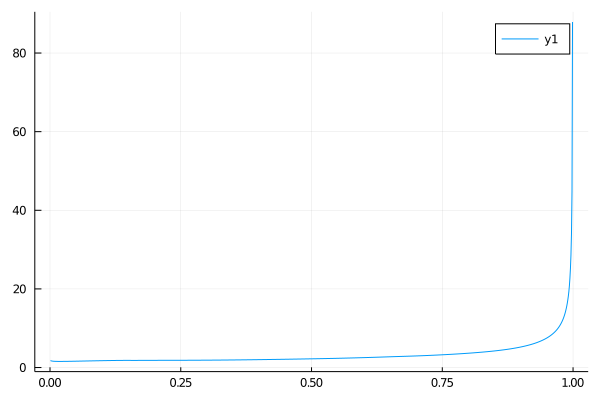

In [49]:
minU = minimum(S[:,ev])
maxU = maximum(S[:,ev])
values = []
for c in range(minU,stop=maxU,length=1000)
    levelset = Main.CoherentStructures.get_levelset(ctx,S[:,ev],c,
        x_resolution=x_resolution,y_resolution=y_resolution,bdata=bdata)
    curves = lines(levelset)
    if (length(curves)>0)
        if length(curves) != 1
            @warn "Currently only connected levelsets are allowed! Levelset: ", level(levelset)
        end
        push!(values,dynamic_cheeger_value(curves[1]))
    else 
        push!(values,0)
    end
end
Plots.plot(range(minU,stop=maxU,length=1000)[2:end-1],values[2:end-1])
Plots.plot!(fmt=:png,dpi=100)

In [50]:
best_levelset, best_value = get_minimal_levelset(
    ctx,S[:,ev],dynamic_cheeger_value,
    x_resolution=x_resolution,y_resolution=y_resolution,bdata=bdata,
    n_candidates=1000,min=0)
print("Dynamic Cheeger value:\t",best_value,"\n")
print("Levelset:\t\t",level(best_levelset),"\n")

Dynamic Cheeger value:	1.5531088772082717
Levelset:		0.01701701701701702


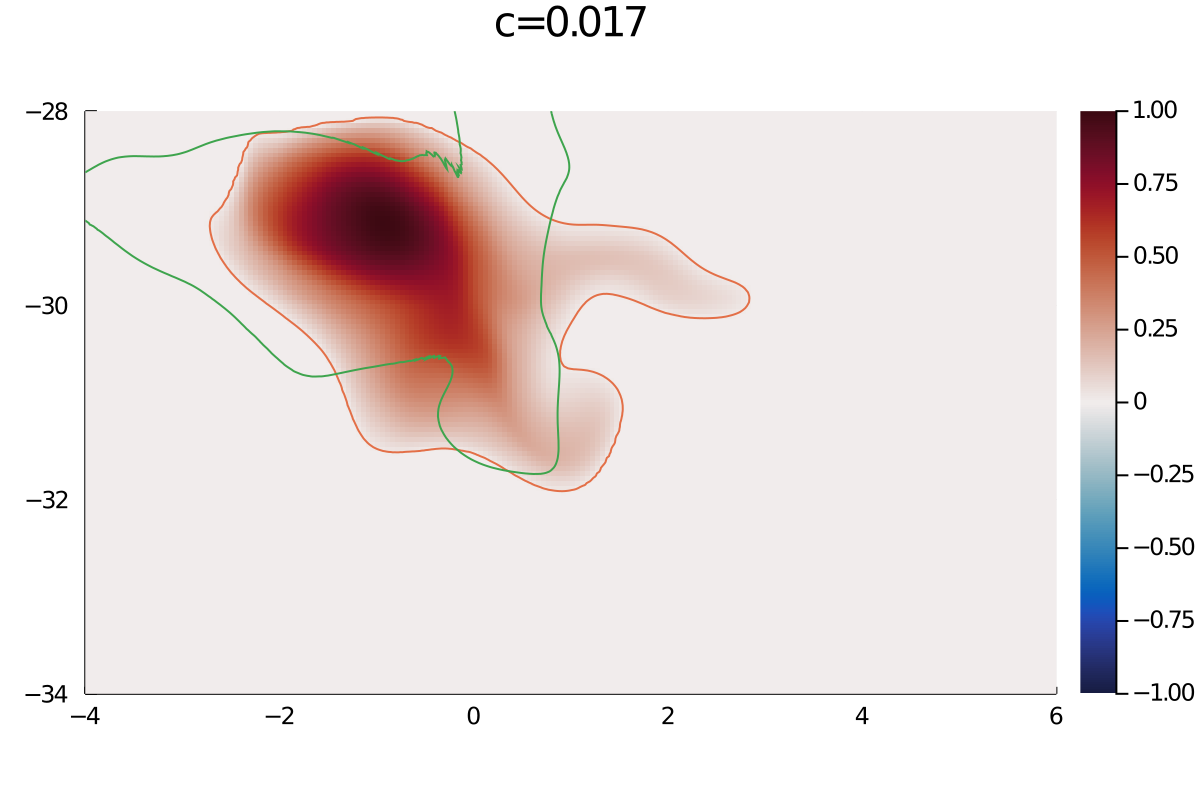

In [51]:
c_best = level(best_levelset)
plot_u(ctx, S[:,ev],  lon_resolution, lat_resolution, bdata=bdata,
        title="c=$(round(c_best,digits=4))",
        colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks,legend=false)

curves = lines(best_levelset)
curves = [Main.CoherentStructures.closeCurve(ctx,c) for c in curves]
curves_moved = [Main.CoherentStructures.apply2curve(x->T(x,0),c) for c in curves]

cheeger_value = dynamic_cheeger_value_matlab(curves[1])

for c in curves
    Plots.plot!(coordinates(c))
end
for c in curves_moved
    Plots.plot!(coordinates(c))
end
Plots.plot!(fmt=:png,dpi=200,legend=false)

In [52]:
plt.figure(figsize=(10,6), dpi=100)
ax = plt.axes()
ax.set(xlim=(-4,6), ylim=(-34,-28))
# this is not completely straightforward due to the nonlinearity of softThreshold!
plot_vectorfield(get_levelset_evolution(ctx,S′[:,ev],S_dot[:,ev],bdata=bdata)...,ax,scale=0.01,step=5)
curves           = lines(get_levelset(ctx, S[:,ev],c_best,
        x_resolution=x_resolution,y_resolution=y_resolution,bdata=bdata))
curves_epsilon   = lines(get_levelset(ctx, Sϵ[:,ev],c_best,
                x_resolution=x_resolution,y_resolution=y_resolution,bdata=bdata))
curves_predicted = lines(get_levelset(ctx, normalizeU(softThreshold(S′[:,ev] + ϵ*S_dot[:,ev],μ)),c_best,
                x_resolution=x_resolution,y_resolution=y_resolution,bdata=bdata))

for c in curves
    ax.plot(coordinates(c)...,color=:black,linewidth=2)
end
for c in curves_epsilon
    ax.plot(coordinates(c)...,color=:red,linestyle="--",linewidth=2)
end
for c in curves_predicted
    ax.plot(coordinates(c)...,color=:lightgreen,linewidth=2)
end
ax.set_title("c=$(round(c_best,digits=4))");

UndefVarError: [91mUndefVarError: S_dot not defined[39m